In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as la
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse

import pyopencl as cl

print('Start', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start 2025-03-30 15:08:58


In [2]:
def print_device_info() :
    print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')

    for platform in cl.get_platforms():
        print('=' * 60)
        print('Platform - Name: ' + platform.name)
        print('Platform - Vendor: ' + platform.vendor)
        print('Platform - Version: ' + platform.version)
        print('Platform - Profile: ' + platform.profile)

    for device in platform.get_devices():
        print(' ' + '-' * 56)
        print(' Device - Name: ' \
        + device.name)
        print(' Device - Type: ' \
        + cl.device_type.to_string(device.type))
        print(' Device - Max Clock Speed: {0} Mhz'\
        .format(device.max_clock_frequency))
        print(' Device - Compute Units: {0}'\
        .format(device.max_compute_units))
        print(' Device - Global Memory: {0:.0f} GB'\
        .format(device.global_mem_size/ 2**30))
#         print(' Device - Global cache: {0:.0f} KB'\
#         .format(device.global_mem_cache_size/ 2**10))
        print(' Device - Constant Memory: {0:.0f} GB'\
        .format(device.max_constant_buffer_size/ 2**30))
        print(' Device - Local Memory: {0:.0f} KB'\
        .format(device.local_mem_size/ 2**10),  '('+cl.device_local_mem_type.to_string(device.local_mem_type)+')')
        print(' Device - Max Buffer/Image Size: {0:.0f} GB'\
        .format(device.max_mem_alloc_size/ 2**30))
        print(' Device - Max Work Group Size: {0:.0f}'\
        .format(device.max_work_group_size))
#         print('\n') 
        
print_device_info()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Dec 13 2024 23:09:21)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M1
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 8
 Device - Global Memory: 5 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 1 GB
 Device - Max Work Group Size: 256


In [3]:
# ready the PyOpenCL environment
platform = cl.get_platforms()[0]

device = platform.get_devices(cl.device_type.GPU)[0]
# device = platform.get_devices(cl.device_type.CPU)[0]
print('Initializing opencl context on', cl.device_type.to_string(device.type).rpartition(' ')[2])

context = cl.Context([device])

queue = cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE)

# program = cl.Program(context, open('PSO-kernel.cl').read()).build()

deviceName = 'OpenCL_' + cl.device_type.to_string(device.type).rpartition(' ')[2]
print('device name:', deviceName)

Initializing opencl context on GPU
device name: OpenCL_GPU


### Monte Carlo simulation of St

In [4]:
# Black-Scholes
from scipy.stats import norm

def BlackScholes(S0, K, r, sigma, T, opttype='P'):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call_price = S0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    put_price = call_price - S0 + np.exp(-r*T)*K
    
    if opttype == 'C':
#         price = S0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
        price = call_price
    elif opttype == 'P':
#         price = np.exp(-r*T)*K*norm.cdf(-d2) - S0*norm.cdf(-d1) 
        price = put_price
    return price

def BlackScholes_matrix(St, K, r, sigma, T, nPeriod, opttype='P'):
    BS = np.zeros_like(St, dtype=np.float32)
    dt = T / nPeriod

    for t in range(nPeriod):
        new_T = dt * (nPeriod - t)
        BS[:,t] = BlackScholes(St[:,t], K, r, sigma, new_T, 'P')
    return BS

In [17]:
class MonteCarloBase:
    # built-in seeds
#     __seed__ = 10001
    __seed__ = 10
#     __seed__ = np.nan
    
    # class initialization
    def __init__(self, S0, r, sigma, T, nPath, nPeriod, K, opttype):
        # init simulation parameters
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.nPath = nPath
        self.nPeriod = nPeriod
        self.K = K
        self.opttype = opttype
        
        # generate St simulation
        self.Z = self.__getZ()
        self.St = self.__getSt()
        self.BS = self.__getBS()
        
    def getSeed(self):
        return self.__seed__
    
    def setSeed(self, seed):
        self.__seed__ = seed
        self.Z = self.__getZ()
        self.St = self.__getSt()
        return
    
    def __getZ(self):
        if self.__seed__ is np.nan:
            rng = np.random.default_rng()  
        else:
            rng = np.random.default_rng(seed=self.__seed__)  
        Z = rng.normal(size=(self.nPath, self.nPeriod)).astype(np.float32)  
        print(f"Z: shape: {Z.shape}")
        return Z
    
    def __getSt(self):
        # pre-compute Geometric Brownian Motion parameters
        dt = self.T / self.nPeriod
        nudt = (self.r - 0.5 * self.sigma**2) * dt       # drift component
        volsdt = self.sigma * np.sqrt(dt)                # diffusion component
        lnS0 = np.log(self.S0)                           # using log normally distributed feature
        
        # log price approach
#         Z = self.__getZ()
#         delta_lnSt = nudt + volsdt * Z    # nPeriod by nPath
        delta_lnSt = nudt + volsdt * self.Z    # nPeriod by nPath
        lnSt = lnS0 + np.cumsum(delta_lnSt, axis=1) 
#         lnSt = np.concatenate( (np.full(shape=(1, nPath), fill_value=lnS0), lnSt))
        St = np.exp(lnSt).astype(np.float32)
        
        return St
    
    def __getBS(self):

        BS = np.zeros_like(self.St, dtype=np.float32)
        dt = self.T / self.nPeriod
        
        for t in range(self.nPeriod):
            new_T = dt * (self.nPeriod - t)
            BS[:,t] = BlackScholes(self.St[:,t], self.K, self.r, self.sigma, new_T, 'P')
        return BS
    
    # Monte Carlo European option - CPU
    def getEuroOption(self):
        opt = None
        
        if self.opttype=='C':  opt = -1
        elif self.opttype=='P':  opt = 1
        
        C_hat_Euro = (np.exp(-self.r*self.T) * np.maximum(0, (self.K - self.St.T[-1])*opt) ).sum() / self.nPath
    
        return C_hat_Euro
    
    # get MC St payoffs
    def getPayoffs(self):
        opt = None
        if opttype=='C':  opt = -1
        elif opttype=='P':  opt = 1
        # immediate exercise payoffs for nPeriod by nPath
        payoffs = np.maximum(0, (K - self.St)*opt)
        
        return payoffs

In [18]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 1.0, 0.03, 0.3, 1.0, 10, 3, 1.1, 'P', 500
mcBase = MonteCarloBase(S0, r, sigma, T, nPath, nPeriod, K, opttype)

Z: shape: (10, 3)


In [19]:
mcBase.Z.shape, mcBase.St.shape

((10, 3), (10, 3))

In [21]:
display(mcBase.St)

array([[0.8219269 , 0.72131324, 0.6268209 ],
       [1.0421038 , 0.9932093 , 1.0101447 ],
       [1.1514468 , 1.3292545 , 1.4360876 ],
       [0.92028177, 0.8034555 , 0.69422203],
       [0.9374823 , 0.92454207, 0.777354  ],
       [0.8175044 , 0.8576585 , 0.6192349 ],
       [0.964962  , 1.0336422 , 0.8671182 ],
       [0.82055914, 0.7156861 , 0.7967037 ],
       [0.9728869 , 0.7002547 , 0.6474994 ],
       [1.1860306 , 1.3993342 , 1.5528983 ]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

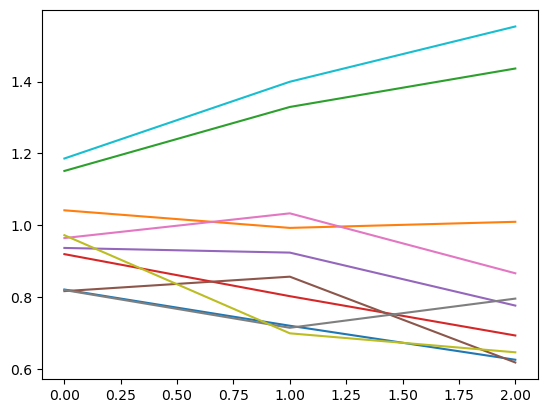

In [26]:
plt.plot(mcBase.St.T)
plt.show

#### Common Function

In [7]:
def checkError(a, b):
    err = a - b
    err_norm = la.norm(err)
    return err_norm

In [8]:
# Classic Adjoint

def inverse_3X3_matrix(A):
    I_Q_list = np.where(isinstance(A, list), A, A.tolist())
    I_Q_list = A
    
    det_ = I_Q_list[0][0] * (
            (I_Q_list[1][1] * I_Q_list[2][2]) - (I_Q_list[1][2] * I_Q_list[2][1])) - \
           I_Q_list[0][1] * (
                   (I_Q_list[1][0] * I_Q_list[2][2]) - (I_Q_list[1][2] * I_Q_list[2][0])) + \
           I_Q_list[0][2] * (
                   (I_Q_list[1][0] * I_Q_list[2][1]) - (I_Q_list[1][1] * I_Q_list[2][0]))
    
    if det_ == 0.0:
        return det_, np.array([[1,0,0],[0,1,0],[0,0,1]]).astype(np.float32)
    
    else:
    
        co_fctr_1 = [(I_Q_list[1][1] * I_Q_list[2][2]) - (I_Q_list[1][2] * I_Q_list[2][1]),
                     -((I_Q_list[1][0] * I_Q_list[2][2]) - (I_Q_list[1][2] * I_Q_list[2][0])),
                     (I_Q_list[1][0] * I_Q_list[2][1]) - (I_Q_list[1][1] * I_Q_list[2][0])]

        co_fctr_2 = [-((I_Q_list[0][1] * I_Q_list[2][2]) - (I_Q_list[0][2] * I_Q_list[2][1])),
                     (I_Q_list[0][0] * I_Q_list[2][2]) - (I_Q_list[0][2] * I_Q_list[2][0]),
                     -((I_Q_list[0][0] * I_Q_list[2][1]) - (I_Q_list[0][1] * I_Q_list[2][0]))]

        co_fctr_3 = [(I_Q_list[0][1] * I_Q_list[1][2]) - (I_Q_list[0][2] * I_Q_list[1][1]),
                     -((I_Q_list[0][0] * I_Q_list[1][2]) - (I_Q_list[0][2] * I_Q_list[1][0])),
                     (I_Q_list[0][0] * I_Q_list[1][1]) - (I_Q_list[0][1] * I_Q_list[1][0])]

        inv_list = [[1 / det_ * (co_fctr_1[0]), 1 / det_ * (co_fctr_2[0]), 1 / det_ * (co_fctr_3[0])],
                    [1 / det_ * (co_fctr_1[1]), 1 / det_ * (co_fctr_2[1]), 1 / det_ * (co_fctr_3[1])],
                    [1 / det_ * (co_fctr_1[2]), 1 / det_ * (co_fctr_2[2]), 1 / det_ * (co_fctr_3[2])]]

        return det_.astype(np.float32), np.array(inv_list).astype(np.float32),# np.array([co_fctr_1, co_fctr_2, co_fctr_3]).astype(np.float32)


In [9]:
# Gauss-Jordan Elimination - row reduction

def GJ_Elimination_inverse_3X3(A):
    B = np.zeros((3,6), dtype=np.float32)
    
    # right joint identity matrix
    for i in range(3):
        for j in range(3):
          B[i][j] = A[i][j]
    
    B[0][3] = 1;
    B[1][4] = 1;
    B[2][5] = 1;
    
    # partial pivoting
    for i in range(2, 0, -1):
#         print(i)
        if (B[i - 1][1] < B[i][1]):
            for j in range(6):
                d = B[i][j];
                B[i][j] = B[i - 1][j];
                B[i - 1][j] = d;
                
    # reducing to diagonal  matrix 
    for i in range(3):
        for j in range(3):
            if (j != i and B[j][i] != 0):
                d = B[j][i] / B[i][i];
                for k in range(6):
                    B[j][k] -= B[i][k] * d;
                    
    # reducing to unit matrix 
    C = np.zeros((3,3), dtype=np.float32)

    C[0][0] = B[0][3] / B[0][0];
    C[0][1] = B[0][4] / B[0][0];
    C[0][2] = B[0][5] / B[0][0];
    C[1][0] = B[1][3] / B[1][1];
    C[1][1] = B[1][4] / B[1][1];
    C[1][2] = B[1][5] / B[1][1];
    C[2][0] = B[2][3] / B[2][2];
    C[2][1] = B[2][4] / B[2][2];
    C[2][2] = B[2][5] / B[2][2];
    
    return C

### Kernel source base

##### Least Squares, Regression, pseudo-inverse

For $Ax=\vec b$, it's called linear system of equations<p>
where $A$ and $\vec b$ are known, to solve $x$<p>

We say the approaximation of x:<p>
$ \tilde x := A^{\dagger} \cdot \vec b$ which satisfies: $min \begin{Vmatrix} A \tilde x - \vec b \end{Vmatrix}_2$, the least squares solution<p>
    
To solve the equation $ Ax= \vec b$<p>
    * We can left dot $A^T$ on both sides of the equation, which gives us $A^T \cdot Ax=A^T \cdot \vec b$<p>
    * Further we yield the new equation $ \tilde x := (A^TA)^{-1} A^T \cdot \vec b$<p>
    * We say $A^{\dagger} = (A^TA)^{-1} A^T$, which is the pseudo-inverse of matrix A
        
##### Matrix basic operations

For input matrices $A_{M*K}$ and $B_{K*N}$, the resulting matrix $C_{M*N}$ can be computed by $c_{ij} = \Sigma (a_{ik} * b_{kj})$<p> for $i \in [0, M], j \in [0,N], k \in [0, K]$

### Kernel source pre-calc

In [10]:
knl_src_pre_calc_ClassicAdjoint_bak = '''
#define n_PATH %d
#define n_PERIOD %d

#ifndef STRIDE
#define STRIDE 3
#endif


__kernel void preCalcAll_ClassicAdjoint(global float* St, float K, char opt, global float* X_big_T, global float* Xdagger_big){

    int gid = get_global_id(0); //period id
    
    if (gid >= n_PERIOD)
        return;
    
    /* 1. generate X_big & 2. generate X_big_T */
    // calc start
    int XbigT_start_idx = gid * STRIDE * n_PATH; 
    
    int itm = 0;
    
    float X0 = 0.0f;
    float X1 = 0.0f;
    float X2 = 0.0f;
    
    for (int i=0; i<n_PATH; i++){
        
        /* 0. generate X */        
        X0 = 1.0f;
        X1 = St[gid + i * n_PERIOD];
        X2 = X1 * X1;
        
        //check in-the-money paths
        float payoff = max(0.0f, (K - X1) * opt);
        
        if (payoff > 0){  
            
            /* 1. generate X_big */
            // compute on-the-fly, no need for storage
            
            /* 2. generate X_big_T */
            X_big_T[XbigT_start_idx + itm + 0 * n_PATH] = X0;
            X_big_T[XbigT_start_idx + itm + 1 * n_PATH] = X1;
            X_big_T[XbigT_start_idx + itm + 2 * n_PATH] = X2;
            
            itm++;
        }
    }
    
    /* 3. each thread calc XTX of per period in private memory */
    
    float XTX[STRIDE * STRIDE] = {0.0f};
    // XTX is diognal, only need to calc upper triangle - 6 values: 0, 1, 2, 4, 5, 8
    
    // calc XTX[0, 1, 2, 4, 5, 8]
    for (int i=0; i<itm; i++){
        
        X0 = X_big_T[XbigT_start_idx + i + 0 * n_PATH];
        X1 = X_big_T[XbigT_start_idx + i + 1 * n_PATH];
        X2 = X_big_T[XbigT_start_idx + i + 2 * n_PATH];
        
        XTX[0] += X0 * X0; 
        XTX[1] += X0 * X1; 
        XTX[2] += X0 * X2; 
        XTX[4] += X1 * X1; 
        XTX[5] += X1 * X2; 
        XTX[8] += X2 * X2; 
    }
    
    XTX[3] = XTX[1];
    XTX[6] = XTX[2];
    XTX[7] = XTX[5];
    
    /* 4. calc XTX inverse */

    /** Classic Adjoint inverse 3X3 **/ 
    float XTX_inv[STRIDE * STRIDE] = {0.0f};
  
    // a. Calculate the determinant of the matrix 
    float det = XTX[0] * (XTX[4] * XTX[8] - XTX[5] * XTX[7])
              - XTX[1] * (XTX[3] * XTX[8] - XTX[5] * XTX[6])
              + XTX[2] * (XTX[3] * XTX[7] - XTX[4] * XTX[6]);

    // b. Check if the determinant is non-zero
    if (det != 0.0f) {       // Calculate the inverse using cofactors and adjugate
        XTX_inv[0] = (XTX[4] * XTX[8] - XTX[5] * XTX[7]) * 1.0 / det;
        XTX_inv[1] = (XTX[2] * XTX[7] - XTX[1] * XTX[8]) * 1.0 / det;
        XTX_inv[2] = (XTX[1] * XTX[5] - XTX[2] * XTX[4]) * 1.0 / det;
        XTX_inv[3] = (XTX[5] * XTX[6] - XTX[3] * XTX[8]) * 1.0 / det;
        XTX_inv[4] = (XTX[0] * XTX[8] - XTX[2] * XTX[6]) * 1.0 / det;
        XTX_inv[5] = (XTX[2] * XTX[3] - XTX[0] * XTX[5]) * 1.0 / det;
        XTX_inv[6] = (XTX[3] * XTX[7] - XTX[4] * XTX[6]) * 1.0 / det;
        XTX_inv[7] = (XTX[1] * XTX[6] - XTX[0] * XTX[7]) * 1.0 / det;
        XTX_inv[8] = (XTX[0] * XTX[4] - XTX[1] * XTX[3]) * 1.0 / det;

    }
    else {        // Matrix is singular, set the inverse to identity matrix
        XTX_inv[0] = 1.0f;
        XTX_inv[1] = 0.0f;
        XTX_inv[2] = 0.0f;
        XTX_inv[3] = 0.0f;
        XTX_inv[4] = 1.0f;
        XTX_inv[5] = 0.0f;
        XTX_inv[6] = 0.0f;
        XTX_inv[7] = 0.0f;
        XTX_inv[8] = 1.0f;
    } 
   
    /* 5 write to XTX_big & XTXinv_big */
    // compute on-the-fly, no need for storage
    
    /* 6. calc Xdagger_big */
    // calc starting index
    int Xdagger_big_start_idx = gid * STRIDE * n_PATH; 
    
    for (int i=0; i<itm; i++){  // loop over paths
    
        X0 = 0.0f;
        X1 = 0.0f;
        X2 = 0.0f;
        
        for (int k=0; k<STRIDE; k++){  //  loop over STRIDE
            //k=0: XTX_inv[0,1,2]; k=1: XTX_inv[3,4,5]; k=2: XTX_inv[6,7,8]            
            X0 += XTX_inv[0 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];
            X1 += XTX_inv[1 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];
            X2 += XTX_inv[2 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];            
        }
        
        Xdagger_big[Xdagger_big_start_idx + i + 0 * n_PATH] = X0;
        Xdagger_big[Xdagger_big_start_idx + i + 1 * n_PATH] = X1;
        Xdagger_big[Xdagger_big_start_idx + i + 2 * n_PATH] = X2;

    }
}

'''

# prog = cl.Program(context, knl_src_pre_calc_ClassicAdjoint%(nPath, nPeriod)).build()
# knl_preCalcAll_ClassicAdjoint = cl.Kernel(prog, 'preCalcAll_ClassicAdjoint')


In [11]:
knl_src_pre_calc_ClassicAdjoint = '''
#define n_PATH %d
#define n_PERIOD %d

#ifndef STRIDE
#define STRIDE 3
#endif


__kernel void preCalcAll_ClassicAdjoint(global float* St, float K, char opt, global float* X_big_T, global float* Xdagger_big){

    int gid = get_global_id(0); //period id
    
    if (gid >= n_PERIOD)
        return;
    
    /* 1. generate X_big & 2. generate X_big_T */
    // calc start
    int XbigT_start_idx = gid * STRIDE * n_PATH; 
    
    int itm = 0;
    
    float X0 = 0.0f;
    float X1 = 0.0f;
    float X2 = 0.0f;
    
    for (int i=0; i<n_PATH; i++){
        
        /* 0. generate X */        
        //X0 = 1.0f;
        //X1 = (K - St[gid + i * n_PERIOD]) * opt;
        //X2 = X1 * X1;
        
        //check in-the-money paths
        float payoff = max(0.0f, (K - St[gid + i * n_PERIOD]) * opt);
        
        if (payoff > 0){  
            
            /* 1. generate X_big */
            // compute on-the-fly, no need for storage
            
            /* 2. generate X_big_T */
                        //use positive payoff as the basis functions:::Normalization to avoid nearly singular matrix
            X_big_T[XbigT_start_idx + itm + 0 * n_PATH] = 1.0f;
            X_big_T[XbigT_start_idx + itm + 1 * n_PATH] = payoff;
            X_big_T[XbigT_start_idx + itm + 2 * n_PATH] = payoff * payoff;
            
            itm++;
        }
    }
    
    /* 3. each thread calc XTX of per period in private memory */
    
    float XTX[STRIDE * STRIDE] = {0.0f};
    // XTX is diognal, only need to calc upper triangle - 6 values: 0, 1, 2, 4, 5, 8
    
    // calc XTX[0, 1, 2, 4, 5, 8]
    for (int i=0; i<itm; i++){
        
        X0 = X_big_T[XbigT_start_idx + i + 0 * n_PATH];
        X1 = X_big_T[XbigT_start_idx + i + 1 * n_PATH];
        X2 = X_big_T[XbigT_start_idx + i + 2 * n_PATH];
        
        XTX[0] += X0 * X0; 
        XTX[1] += X0 * X1; 
        XTX[2] += X0 * X2; 
        XTX[4] += X1 * X1; 
        XTX[5] += X1 * X2; 
        XTX[8] += X2 * X2; 
    }
    
    XTX[3] = XTX[1];
    XTX[6] = XTX[2];
    XTX[7] = XTX[5];
    
    /* 4. calc XTX inverse */

    /** Classic Adjoint inverse 3X3 **/ 
    float XTX_inv[STRIDE * STRIDE] = {0.0f};
  
    // a. Calculate the determinant of the matrix 
    float det = XTX[0] * (XTX[4] * XTX[8] - XTX[5] * XTX[7])
              - XTX[1] * (XTX[3] * XTX[8] - XTX[5] * XTX[6])
              + XTX[2] * (XTX[3] * XTX[7] - XTX[4] * XTX[6]);

    // b. Check if the determinant is non-zero
    if (det != 0.0f) {       // Calculate the inverse using cofactors and adjugate
        XTX_inv[0] = (XTX[4] * XTX[8] - XTX[5] * XTX[7]) * 1.0 / det;
        XTX_inv[1] = (XTX[2] * XTX[7] - XTX[1] * XTX[8]) * 1.0 / det;
        XTX_inv[2] = (XTX[1] * XTX[5] - XTX[2] * XTX[4]) * 1.0 / det;
        XTX_inv[3] = (XTX[5] * XTX[6] - XTX[3] * XTX[8]) * 1.0 / det;
        XTX_inv[4] = (XTX[0] * XTX[8] - XTX[2] * XTX[6]) * 1.0 / det;
        XTX_inv[5] = (XTX[2] * XTX[3] - XTX[0] * XTX[5]) * 1.0 / det;
        XTX_inv[6] = (XTX[3] * XTX[7] - XTX[4] * XTX[6]) * 1.0 / det;
        XTX_inv[7] = (XTX[1] * XTX[6] - XTX[0] * XTX[7]) * 1.0 / det;
        XTX_inv[8] = (XTX[0] * XTX[4] - XTX[1] * XTX[3]) * 1.0 / det;

    }
    else {        // Matrix is singular, set the inverse to identity matrix
        XTX_inv[0] = 1.0f;
        XTX_inv[1] = 0.0f;
        XTX_inv[2] = 0.0f;
        XTX_inv[3] = 0.0f;
        XTX_inv[4] = 1.0f;
        XTX_inv[5] = 0.0f;
        XTX_inv[6] = 0.0f;
        XTX_inv[7] = 0.0f;
        XTX_inv[8] = 1.0f;
    } 
   
    /* 5 write to XTX_big & XTXinv_big */
    // compute on-the-fly, no need for storage
    
    /* 6. calc Xdagger_big */
    // calc starting index
    int Xdagger_big_start_idx = gid * STRIDE * n_PATH; 
    
    for (int i=0; i<itm; i++){  // loop over paths
    
        X0 = 0.0f;
        X1 = 0.0f;
        X2 = 0.0f;
        
        for (int k=0; k<STRIDE; k++){  //  loop over STRIDE
            //k=0: XTX_inv[0,1,2]; k=1: XTX_inv[3,4,5]; k=2: XTX_inv[6,7,8]            
            X0 += XTX_inv[0 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];
            X1 += XTX_inv[1 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];
            X2 += XTX_inv[2 * STRIDE + k] * X_big_T[XbigT_start_idx + i + k * n_PATH];            
        }
        
        Xdagger_big[Xdagger_big_start_idx + i + 0 * n_PATH] = X0;
        Xdagger_big[Xdagger_big_start_idx + i + 1 * n_PATH] = X1;
        Xdagger_big[Xdagger_big_start_idx + i + 2 * n_PATH] = X2;

    }
}

'''

# prog = cl.Program(context, knl_src_pre_calc_ClassicAdjoint%(nPath, nPeriod)).build()
# knl_preCalcAll_ClassicAdjoint = cl.Kernel(prog, 'preCalcAll_ClassicAdjoint')


In [12]:
knl_src_pre_calc_GaussJordan_bak = '''
#define n_PATH %d
#define n_PERIOD %d

#ifndef STRIDE
#define STRIDE 3
#endif


__kernel void preCalcAll_GaussJordan(global float* St, float K, char opt, global float* X_big_T, global float* Xdagger_big){

    int gid = get_global_id(0); //period id
    
    if (gid >= n_PERIOD)
        return;
    
    /* 1. generate X_big & 2. generate X_big_T */
    // calc start
    int X_big_T_start_idx = gid * STRIDE * n_PATH; 
    
    int itm = 0;
    
    float X0 = 0.0f;
    float X1 = 0.0f;
    float X2 = 0.0f;
    
    for (int i=0; i<n_PATH; i++){
        
        /* 0. generate X */        
        X0 = 1.0f;
        X1 = St[gid + i * n_PERIOD];
        X2 = X1 * X1;
        
        //check in the money
        float payoff = max(0.0f, (K - X1) * opt);
        
        if (payoff > 0){  
            
            /* 1. generate X_big */
            // compute on-the-fly, no need for storage
            
            /* 2. generate X_big_T */
            X_big_T[X_big_T_start_idx + itm + 0 * n_PATH] = X0;
            X_big_T[X_big_T_start_idx + itm + 1 * n_PATH] = X1;
            X_big_T[X_big_T_start_idx + itm + 2 * n_PATH] = X2;
            
            itm++;
        }
    }
    
    /* 3. each thread calc XTX of per period in private memory */
    
    float XTX[STRIDE * STRIDE] = {0.0f};
    // XTX is diognal, only need to calc upper triangle - 6 values: 0, 1, 2, 4, 5, 8
    
    // calc XTX[0, 1, 2, 4, 5, 8]
    for (int i=0; i<itm; i++){
        
        X0 = X_big_T[X_big_T_start_idx + i + 0 * n_PATH];
        X1 = X_big_T[X_big_T_start_idx + i + 1 * n_PATH];
        X2 = X_big_T[X_big_T_start_idx + i + 2 * n_PATH];
        
        XTX[0] += X0 * X0; 
        XTX[1] += X0 * X1; 
        XTX[2] += X0 * X2; 
        XTX[4] += X1 * X1; 
        XTX[5] += X1 * X2; 
        XTX[8] += X2 * X2; 
    }
    
    XTX[3] = XTX[1];
    XTX[6] = XTX[2];
    XTX[7] = XTX[5];
    
    /* 4. calc XTX inverse */
    
    /** Gauss-Jordan Elimination inverse 3X3 **/
    float XTX_inv[STRIDE * STRIDE] = {0.0f};
    
    //define interim right joint matrix
    float right_joint[STRIDE][STRIDE * 2] = {0.0f};
    float d = 0.0f;
    
    // a. right joint identity matrix
    for (int i=0; i<STRIDE; i++){
        for (int j=0; j<STRIDE; j++){
            right_joint[i][j] = XTX[i * STRIDE + j];
        }
    }
    
    right_joint[0][3] = 1.0f;
    right_joint[1][4] = 1.0f;
    right_joint[2][5] = 1.0f;
    
    // b. partial pivoting
    for (int i=STRIDE-1; i>0; i--){
        if (right_joint[i-1][1] < right_joint[i][1]){
            for (int j=0; j<STRIDE*2; j++){
                d = right_joint[i][j];
                right_joint[i][j] = right_joint[i - 1][j];
                right_joint[i - 1][j] = d;
            }
        }
    }
                
    // c. reducing to diagonal  matrix 
    for (int i=0; i<STRIDE; i++){
        for (int j=0; j<STRIDE; j++){
            if (j != i && right_joint[j][i] != 0){
                d = right_joint[j][i] / right_joint[i][i];
                for (int k=0; k<STRIDE*2; k++){
                    right_joint[j][k] -= right_joint[i][k] * d;
                }
            }
        }
    }
                    
    // d. reducing to unit matrix 
    XTX_inv[0] = right_joint[0][3] / right_joint[0][0];
    XTX_inv[1] = right_joint[0][4] / right_joint[0][0];
    XTX_inv[2] = right_joint[0][5] / right_joint[0][0];
    XTX_inv[3] = right_joint[1][3] / right_joint[1][1];
    XTX_inv[4] = right_joint[1][4] / right_joint[1][1];
    XTX_inv[5] = right_joint[1][5] / right_joint[1][1];
    XTX_inv[6] = right_joint[2][3] / right_joint[2][2];
    XTX_inv[7] = right_joint[2][4] / right_joint[2][2];
    XTX_inv[8] = right_joint[2][5] / right_joint[2][2];
    
   
   
    /* 5 write to XTX_big & XTXinv_big */
    // compute on-the-fly, no need for storage
    
    /* 6. calc Xdagger_big */
    // calc starting index
    int Xdagger_big_start_idx = gid * STRIDE * n_PATH; 
    
    for (int i=0; i<itm; i++){  // loop over paths
    
        X0 = 0.0f;
        X1 = 0.0f;
        X2 = 0.0f;
        
        for (int k=0; k<STRIDE; k++){  //  loop over STRIDE
            //k=0: XTX_inv[0,1,2]; k=1: XTX_inv[3,4,5]; k=2: XTX_inv[6,7,8]            
            X0 += XTX_inv[0 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];
            X1 += XTX_inv[1 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];
            X2 += XTX_inv[2 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];            
        }
        
        Xdagger_big[Xdagger_big_start_idx + i + 0 * n_PATH] = X0;
        Xdagger_big[Xdagger_big_start_idx + i + 1 * n_PATH] = X1;
        Xdagger_big[Xdagger_big_start_idx + i + 2 * n_PATH] = X2;

    }
}

'''

# prog = cl.Program(context, knl_src_pre_calc_GaussJordan%(nPath, nPeriod)).build()
# knl_preCalcAll_GaussJordan = cl.Kernel(prog, 'preCalcAll_GaussJordan')


In [13]:
knl_src_pre_calc_GaussJordan = '''
#define n_PATH %d
#define n_PERIOD %d

#ifndef STRIDE
#define STRIDE 3
#endif


__kernel void preCalcAll_GaussJordan(global float* St, float K, char opt, global float* X_big_T, global float* Xdagger_big){

    int gid = get_global_id(0); //period id
    
    if (gid >= n_PERIOD)
        return;
    
    /* 1. generate X_big & 2. generate X_big_T */
    // calc start
    int X_big_T_start_idx = gid * STRIDE * n_PATH; 
    
    int itm = 0;
    
    float X0 = 0.0f;
    float X1 = 0.0f;
    float X2 = 0.0f;
    
    for (int i=0; i<n_PATH; i++){
        
        /* 0. generate X */        
        //X0 = 1.0f;
        //X1 = (K - St[gid + i * n_PERIOD]) * opt;
        //X2 = X1 * X1;
        
        //check in the money
        float payoff = max(0.0f, (K - St[gid + i * n_PERIOD]) * opt);
        
        if (payoff > 0){  
            
            /* 1. generate X_big */
            // compute on-the-fly, no need for storage
            
            /* 2. generate X_big_T */
            //use positive payoff as the basis functions:::Normalization to avoid nearly singular matrix
            X_big_T[X_big_T_start_idx + itm + 0 * n_PATH] = 1.0f;
            X_big_T[X_big_T_start_idx + itm + 1 * n_PATH] = payoff;
            X_big_T[X_big_T_start_idx + itm + 2 * n_PATH] = payoff * payoff;
            
            itm++;
        }
    }
    
    /* 3. each thread calc XTX of per period in private memory */
    
    float XTX[STRIDE * STRIDE] = {0.0f};
    // XTX is diognal, only need to calc upper triangle - 6 values: 0, 1, 2, 4, 5, 8
    
    // calc XTX[0, 1, 2, 4, 5, 8]
    for (int i=0; i<itm; i++){
        
        X0 = X_big_T[X_big_T_start_idx + i + 0 * n_PATH];
        X1 = X_big_T[X_big_T_start_idx + i + 1 * n_PATH];
        X2 = X_big_T[X_big_T_start_idx + i + 2 * n_PATH];
        
        XTX[0] += X0 * X0; 
        XTX[1] += X0 * X1; 
        XTX[2] += X0 * X2; 
        XTX[4] += X1 * X1; 
        XTX[5] += X1 * X2; 
        XTX[8] += X2 * X2; 
    }
    
    XTX[3] = XTX[1];
    XTX[6] = XTX[2];
    XTX[7] = XTX[5];
    
    /* 4. calc XTX inverse */
    
    /** Gauss-Jordan Elimination inverse 3X3 **/
    float XTX_inv[STRIDE * STRIDE] = {0.0f};
    
    //define interim right joint matrix
    float right_joint[STRIDE][STRIDE * 2] = {0.0f};
    float d = 0.0f;
    
    // a. right joint identity matrix
    for (int i=0; i<STRIDE; i++){
        for (int j=0; j<STRIDE; j++){
            right_joint[i][j] = XTX[i * STRIDE + j];
        }
    }
    
    right_joint[0][3] = 1.0f;
    right_joint[1][4] = 1.0f;
    right_joint[2][5] = 1.0f;
    
    // b. partial pivoting
    for (int i=STRIDE-1; i>0; i--){
        if (right_joint[i-1][1] < right_joint[i][1]){
            for (int j=0; j<STRIDE*2; j++){
                d = right_joint[i][j];
                right_joint[i][j] = right_joint[i - 1][j];
                right_joint[i - 1][j] = d;
            }
        }
    }
                
    // c. reducing to diagonal  matrix 
    for (int i=0; i<STRIDE; i++){
        for (int j=0; j<STRIDE; j++){
            if (j != i && right_joint[j][i] != 0){
                d = right_joint[j][i] / right_joint[i][i];
                for (int k=0; k<STRIDE*2; k++){
                    right_joint[j][k] -= right_joint[i][k] * d;
                }
            }
        }
    }
                    
    // d. reducing to unit matrix 
    XTX_inv[0] = right_joint[0][3] / right_joint[0][0];
    XTX_inv[1] = right_joint[0][4] / right_joint[0][0];
    XTX_inv[2] = right_joint[0][5] / right_joint[0][0];
    XTX_inv[3] = right_joint[1][3] / right_joint[1][1];
    XTX_inv[4] = right_joint[1][4] / right_joint[1][1];
    XTX_inv[5] = right_joint[1][5] / right_joint[1][1];
    XTX_inv[6] = right_joint[2][3] / right_joint[2][2];
    XTX_inv[7] = right_joint[2][4] / right_joint[2][2];
    XTX_inv[8] = right_joint[2][5] / right_joint[2][2];
    
   
   
    /* 5 write to XTX_big & XTXinv_big */
    // compute on-the-fly, no need for storage
    
    /* 6. calc Xdagger_big */
    // calc starting index
    int Xdagger_big_start_idx = gid * STRIDE * n_PATH; 
    
    for (int i=0; i<itm; i++){  // loop over paths
    
        X0 = 0.0f;
        X1 = 0.0f;
        X2 = 0.0f;
        
        for (int k=0; k<STRIDE; k++){  //  loop over STRIDE
            //k=0: XTX_inv[0,1,2]; k=1: XTX_inv[3,4,5]; k=2: XTX_inv[6,7,8]            
            X0 += XTX_inv[0 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];
            X1 += XTX_inv[1 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];
            X2 += XTX_inv[2 * STRIDE + k] * X_big_T[X_big_T_start_idx + i + k * n_PATH];            
        }
        
        Xdagger_big[Xdagger_big_start_idx + i + 0 * n_PATH] = X0;
        Xdagger_big[Xdagger_big_start_idx + i + 1 * n_PATH] = X1;
        Xdagger_big[Xdagger_big_start_idx + i + 2 * n_PATH] = X2;

    }
}

'''

# prog = cl.Program(context, knl_src_pre_calc_GaussJordan%(nPath, nPeriod)).build()
# knl_preCalcAll_GaussJordan = cl.Kernel(prog, 'preCalcAll_GaussJordan')


## Longstaff Schwartz

For $Ax=\vec b$, it's called linear system of equations<p>
where $A$ and $\vec b$ are known, to solve $x$<p>

We say the approaximation of x:<p>
$ \tilde x := A^{\dagger} \cdot \vec b$ which satisfies: $min \begin{Vmatrix} A \tilde x - \vec b \end{Vmatrix}_2$, the least squares solution

##### Numpy version

In [14]:
# calculate conditional expectation of Continuation, follow matrix linear algebra form
def continuation_value2(x, Y, log, inverseType='benchmark_pinv'):
#     poly = 2        # polynomial to generate X matrix
    
    # X matraix contains constant, x...x^poly   
    X = np.c_[np.ones(len(x)), x, np.square(x)].astype(np.float32)
    
    # conditional expectation function E[Y|X] = coef_[0] + coef_[1]*x + ... + coef_[poly]*x^poly
    match inverseType:
        case "benchmark_pinv":  
            Xdagger = np.linalg.pinv(X)     # standard Numpy function for pseudo-inverse
            coef_ = Xdagger @ Y
        case "benchmark_lstsq":
            coef_ = np.linalg.lstsq(X, Y, rcond=None)[0]
        case "SVD":
            U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
            Xdagger = VT.T @ np.linalg.inv(np.diag(Sigma)) @ U.T
            coef_ = Xdagger @ Y
        case "CA":
            Xdagger = inverse_3X3_matrix(X.T @ X)[1] @ X.T
            coef_ = Xdagger @ Y

        case "GJ":
            Xdagger = GJ_Elimination_inverse_3X3(X.T @ X) @ X.T
            coef_ = Xdagger @ Y
            
#     Xdagger = np.linalg.inv(X.T @ X) @ X.T            ##### SHOULD NOT be used, use pinv instead

    if (log=='INFO'):
        print('X:\n',X)
        print('Y:', Y.flatten())
        print('Xdagger:\n', Xdagger)

    cont_value = X @ coef_
    return cont_value, coef_

def longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType='benchmark', toggleCV='OFF', log=None):
    
    St = St.T  # input St is nPath by nPeriod, need to transpose for Numpy
    nPeriod, nPath = St.shape[0], St.shape[1]
    
    # setup computing components
    dt = T / nPeriod
    df = np.exp(-r * dt)
    
    # track discounted cashflow per time step
    dc_cashflow_t = []
    coef_t = []
    
    # case based option payoff
    opt = None
    if opttype=='C':  opt = -1
    elif opttype=='P':  opt = 1
    # immediate exercise payoffs for nPeriod by nPath
    payoffs = np.maximum(0, (K - St)*opt)
    
    # initiate cashflow as of time maturity
    dc_cashflow = payoffs[-1]
    
    for t in range(nPeriod-2, -1, -1):
        if (log=='INFO'):
            print('\ntime t:', t+1)
        
        # 1. discount cashflow of time t+1 to time t
        dc_cashflow = dc_cashflow * df
        
        # 2. in-the-money paths & numbers
        itm = payoffs[t].nonzero()
        num_itm = np.count_nonzero(payoffs[t])
        
        # 3. construct x and Y
#         x = St[t][itm]           # St at time t for basis function to generate X
        x = K - St[t][itm]           ### (K-St) at time t for basis function to generate X::Normalization to avoid nearly singular matrix
        Y = dc_cashflow[itm].reshape(num_itm, 1)   # discounted cashflow as dependent variable
        
        # 4. calc continuation values
        cont_value, coef_ = continuation_value2(x, Y, log, inverseType)
#         coef_ = np.polyfit(x, Y, 2)
#         cont_value = np.polyval(coef_, x)
#         coef_ = np.flip(coef_)
        
        coef_t.append(coef_.flatten())
        
        if (log=='INFO'):
            print('coef:', coef_.flatten())
            print('pre ds cf itm :', dc_cashflow[itm])
            print('cont val      :', cont_value.flatten())
            print('exer val      :', payoffs[t][itm])
        
        # 5. update cashflow for time t
        if toggleCV=='ON':
            # control variate with Black-Scholes for time step t in-the-money paths
            BS_itm = BS[itm, t].flatten()        
            max_CvBS = np.maximum(cont_value.flatten(), BS_itm)
            dc_cashflow[itm] = np.where(payoffs[t][itm] > max_CvBS, payoffs[t][itm], dc_cashflow[itm])  
        elif toggleCV=='OFF':
            # follow the original Longstaff-Schwartz LSMC method
            dc_cashflow[itm] = np.where(payoffs[t][itm] > cont_value.flatten(), payoffs[t][itm], dc_cashflow[itm])
            
#         dc_cashflow[itm] = np.where(payoffs[t][itm] > cont_value.flatten(), payoffs[t][itm], dc_cashflow[itm]) 
        dc_cashflow_t.append(dc_cashflow)  # insert current time step discounted cashflow
        
        if (log=='INFO'):
            print('post ds cf itm:', dc_cashflow)     

    # discount cashflow to time zero for option pricing
    C_hat = np.sum(dc_cashflow) * df / nPath

    return C_hat, np.array(coef_t), np.array(dc_cashflow_t)
#     # return the coef_t and dc_cashflow_t in reverse order
#     return C_hat, np.flip(np.array(coef_t)), np.flip(np.array(dc_cashflow_t))

##### Hybrid version (GPU and CPU)

##### Extensive Experiment - winning solution!! Stablizing GPU results

* Using Black-Sholes matrix, where each cell is the Black-Sholes price on time step i and path j with the close formula. 
* When updating the discounted cashflow vector, instead of comparing Exercise values against Contiuation values, use the condition: **Exercise values > max{Contiuation values, Black-Sholes values}**, for all in-the-money paths at each time step, everything else stays the same

In [15]:
# calculate to generate Xdagger, pseudo-inverse of all Xs (each X per period)
def preCalc_gpu(St, K, nPath, nPeriod, opt, inverseType='CA'):     # St in shape of nPath by nPeriod    
    """
    Parameters
    ----------
    St : stock price matrix 
        from Monte-Carlo simulation
    K : float
        The strick price
    nPath : int
        The number of simulation paths
    nPeriod : int
        The number of simulation time steps
    opt : char
        Indicates Put or Call options
    inverseType : str, optional
        The GPU matrix inversion method. Default value is 'GJ' using Gauss-Jordan Elimination. Can be set to
        'CA' for Classic Adjoint
    """
    # polynomial to the power 2
    stride = 3
    
    # set up buffer on device
    St_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=St.flatten())

    X_big_T = np.zeros((stride*nPeriod, nPath), dtype=np.float32)
    X_big_T_d = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=X_big_T.nbytes)

    Xdagger_big = np.zeros((stride*nPeriod, nPath), dtype=np.float32)
    Xdagger_big_d = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, size=Xdagger_big.nbytes)
    
    if inverseType=='GJ':  
        prog = cl.Program(context, knl_src_pre_calc_GaussJordan%(nPath, nPeriod)).build()
        knl_preCalcAll = cl.Kernel(prog, 'preCalcAll_GaussJordan')
    elif inverseType=='CA':  
        prog = cl.Program(context, knl_src_pre_calc_ClassicAdjoint%(nPath, nPeriod)).build()
        knl_preCalcAll = cl.Kernel(prog, 'preCalcAll_ClassicAdjoint')
    else:
        raise Exception('Wrong value for inverseType, can ONLY be GJ or CA')
    
    # kernel run
    knl_preCalcAll.set_args(St_d, np.float32(K), opt, X_big_T_d, Xdagger_big_d)
    
    global_size = (nPeriod, )
    local_size = None
    evt = cl.enqueue_nd_range_kernel(queue, knl_preCalcAll, global_size, local_size)
    evt.wait()

    cl.enqueue_copy(queue, X_big_T, X_big_T_d)
    cl.enqueue_copy(queue, Xdagger_big, Xdagger_big_d)
    
    queue.finish()
        
    # release memory
    St_d.release()
    X_big_T_d.release()
    Xdagger_big_d.release()

    return Xdagger_big , X_big_T

def longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType='GJ', toggleCV='ON', log=None):
    """
    Parameters
    ----------
    St : float  
        Stock price matrix from Monte-Carlo simulation
    K : float
        The strick price
    T : float
        The time to maturity
    r : float
        The risk free interest rate
    opttype : str
        The toggle for options type, 'P' for put, 'C' for call
    BS : float
        Black-Scholes matrix from St
    inverseType : str
        The GPU matrix inversion method. 
    toggleCV : str, optional
        The toggle incorporates control variate with Black-Scholes values to adjust discounted cashflow at each time step. Default value is 'ON'. Can be set to 'OFF'
    log : str, optional
        The toggle to turn log on or off. Default is None
    """

    # track discounted cashflow per time step
    dc_cashflow_t = []
    coef_t = []
    
    # polynomial to the power 2
    stride = 3
    
    # in the hybrid version, St is transposed with the numpy version
    nPath, nPeriod = St.shape[0], St.shape[1]
    # setup computing components
    dt = T / nPeriod
    df = np.exp(-r * dt)
    
    # case based option payoff
    opt = None
    if opttype=='C':  opt = np.int8(-1)
    elif opttype=='P':  opt = np.int8(1)
    # immediate exercise payoffs for nPath by nPeriod
    payoffs = np.maximum(0, (K - St)*opt)
    
#     itm_allPeriod = np.count_nonzero(np.maximum(0, (K - St)*opt), axis=0).astype(np.int32)
    itm_allPeriod = (payoffs!=0).sum(0)
    
    # initiate cashflow as of time maturity
    dc_cashflow = payoffs[:, -1]
    
    # Pre-calc
    Xdagger_big, X_big_T = preCalc_gpu(St, K, nPath, nPeriod, opt, inverseType=inverseType)
    
    for t in range(nPeriod-2, -1, -1):
#         print(t+1)
        if (log=='INFO'):
            print('\ntime t:', t+1)
        
        # 1. discount cashflow of time t+1 to time t
        dc_cashflow = dc_cashflow * df
        
        # 2. in-the-money paths & numbers
        itm = payoffs[:, t].nonzero()
        num_itm = itm_allPeriod[t]
        
        # 3. construct X and Y
        X = X_big_T[t*stride:t*stride+stride, :num_itm].T #.reshape(num_itm, 3)

        Xdagger = Xdagger_big[t*stride:t*stride+stride, :num_itm] #.reshape(3, num_itm) 
        
        Y = dc_cashflow[itm].reshape(num_itm, 1)   # discounted cashflow as dependent variable
        coef_ = Xdagger @ Y
        coef_t.append(coef_.flatten())
        
        # 4. calc continuation values
        cont_value = X @ coef_
        
        if (log=='INFO'):
            print('X:\n',X)
            print('Y:', Y.flatten())
            print('Xdagger:\n', Xdagger)
            print('coef:', coef_.flatten())
            print('pre ds cf itm :', dc_cashflow[itm])
            print('cont val      :', cont_value.flatten())
            print('exer val      :', payoffs[:, t][itm])
    
        # 5. update cashflow for time t
        if toggleCV=='ON':
            # control variate with Black-Scholes for time step t in-the-money paths
            BS_itm = BS[itm, t].flatten()        
            max_CvBS = np.maximum(cont_value.flatten(), BS_itm)
            dc_cashflow[itm] = np.where(payoffs[:, t][itm] > max_CvBS, payoffs[:,t][itm], dc_cashflow[itm])  
        elif toggleCV=='OFF':
            # follow the original Longstaff-Schwartz LSMC method
            dc_cashflow[itm] = np.where(payoffs[:, t][itm] > cont_value.flatten(), payoffs[:,t][itm], dc_cashflow[itm])  
            
        dc_cashflow_t.append(dc_cashflow)  # insert current time step discounted cashflow
        
        if (log=='INFO'):
            print('post ds cf itm:', dc_cashflow)     

    # discount cashflow to time zero for option pricing
    C_hat = np.sum(dc_cashflow) * df / nPath

    return C_hat, np.array(coef_t), np.array(dc_cashflow_t)
#     # return the coef_t and dc_cashflow_t in reverse order
#     return C_hat, np.flip(np.array(coef_t)), np.flip(np.array(dc_cashflow_t))

##### Hybrid version using SVD
Instead of pre-calc for Xdagger_big, it uses GPU to calc XT @ X<p>
Then use CPU Numpy to run SVD:<p>
* Reduced SVD of $X$ is defined as $X=U_r \Sigma V_r^T$ 
* Then $X^{\dagger} = V_r \Sigma^{-1} U_r^T$
* Hence for $X \beta=y$ we can have $\hat\beta = V_r \Sigma^{-1} U_r^T \cdot y$
<p>where $r$ is the rank of $X$

In [16]:
# Function to perform matrix multiplication
def matmul(A, B, context, queue):
    A_rows, A_cols = A.shape
    B_rows, B_cols = B.shape
    assert A_cols == B_rows, "Inner dimensions must match for matrix multiplication."
    
    # Kernel to compute matrix multiplication
    kernel_code = """
    __kernel void matmul(__global float* A, __global float* B, __global float* C, int A_rows, int A_cols, int B_cols) {
        //int i = get_global_id(0);
        //int j = get_global_id(1);

        //float sum = 0.0f;
        //for (int k = 0; k < A_cols; ++k) {
        //    sum += A[i * A_cols + k] * B[k * B_cols + j];
        //}
        //C[i * B_cols + j] = sum;
        
        int gid = get_global_id(0);
    
        int row = gid / B_cols;
        int col = gid % B_cols;

        float sum = 0.0f;

        for (int i=0; i < A_cols; i++){   // calculate result of one element of Matrix C 
            sum += A[ row * A_cols + i ] * B[ col + i * B_cols];
        }

        C[ row * B_cols + col ] = sum;
    }
    """
    

    # Prepare buffers
#     St_d = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=St.flatten())
    A_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=A.flatten())
    B_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=B.flatten())
    C = np.empty((A_rows, B_cols), dtype=np.float32)
    C_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, C.nbytes)
        
    # Launch kernel
    prog = cl.Program(context, kernel_code).build()
    knl_matmul = cl.Kernel(prog, 'matmul')
    
    # run kernel
    knl_matmul.set_args(A_buf, B_buf, C_buf, np.int32(A_rows), np.int32(A_cols), np.int32(B_cols))
    
    global_size = (A_rows, B_cols)
    local_size = None
    evt = cl.enqueue_nd_range_kernel(queue, knl_matmul, global_size, local_size)
    evt.wait()
    
#     program.matmul(queue, (A_rows, B_cols), None, A_buf, B_buf, C_buf, np.int32(A_rows), np.int32(A_cols), np.int32(B_cols))

    # Read the result
    cl.enqueue_copy(queue, C, C_buf)
    
    queue.finish()
        
    # release memory
    A_buf.release()
    B_buf.release()
    C_buf.release()
    
    return C

# calculate conditional expectation of Continuation, follow matrix linear algebra form
def continuation_SVD(x, Y, log):
#     poly = 2        # polynomial to generate X matrix
    
    # X matraix contains constant, x...x^poly   
    X = np.c_[np.ones(len(x)), x, np.square(x)].astype(np.float32)
    Y = Y.astype(np.float32)
    
    
    # Compute A^T A using OpenCL
    XT = X.T
    XTX = matmul(XT, X, context, queue)
#     print("X^T X:\n", XTX)

    # Perform SVD on A^T A using NumPy
    U, Sigma, VT = np.linalg.svd(XTX, full_matrices=False)
#     print(Sigma)
    Sigma_inv = np.zeros_like(np.diag(Sigma), dtype=np.float32)
    for i in range(len(Sigma)):
        if Sigma[i] > 1e-10:  # Avoid division by zero
            Sigma_inv[i, i] = 1.0 / Sigma[i]

    # Compute pseudo-inverse (A^T A)^-1 A^T
    XTX_inv = VT.T @ Sigma_inv @ U.T
#     XTX_inv = VT.T @ np.linalg.inv(np.diag(Sigma)) @ U.T
    Xdagger = XTX_inv @ XT
#     print("Pseudo-Inverse X^+:\n", Xdagger)

        
    if (log=='INFO'):
        print('X:\n',X)
        print('Y:', Y.flatten())
        print('Xdagger:\n', Xdagger)
    
    # conditional expectation function E[Y|X] = coef_[0] + coef_[1]*x + ... + coef_[poly]*x^poly
    # Compute least squares solution x = A^+ b
    coef_ = Xdagger @ Y

    cont_value = X @ coef_
    return cont_value, coef_

def longstaff_schwartz_itm_path_fast2_hybrid_SVD(St, K, T, r, opttype, BS, inverseType='benchmark', toggleCV='OFF', log=None):
    
    St = St.T  # input St is nPath by nPeriod, need to transpose for Numpy
    nPeriod, nPath = St.shape[0], St.shape[1]
    # setup computing components
    dt = T / nPeriod
    df = np.exp(-r * dt)
    
    # track discounted cashflow per time step
    dc_cashflow_t = []
    coef_t = []
    
    # case based option payoff
    opt = None
    if opttype=='C':  opt = -1
    elif opttype=='P':  opt = 1
    # immediate exercise payoffs for nPeriod by nPath
    payoffs = np.maximum(0, (K - St)*opt)
    
    # initiate cashflow as of time maturity
    dc_cashflow = payoffs[-1]
    
    for t in range(nPeriod-2, -1, -1):
        if (log=='INFO'):
            print('\ntime t:', t+1)
        
        # 1. discount cashflow of time t+1 to time t
        dc_cashflow = dc_cashflow * df
        
        # 2. in-the-money paths & numbers
        itm = payoffs[t].nonzero()
        num_itm = np.count_nonzero(payoffs[t])
        
        # 3. construct x and Y
#         x = St[t][itm]           # St at time t for basis function to generate X
        x = K - St[t][itm]           ### (K-St) at time t for basis function to generate X::Normalization to avoid nearly singular matrix
        Y = dc_cashflow[itm].reshape(num_itm, 1)   # discounted cashflow as dependent variable
        
        # 4. calc continuation values
        cont_value, coef_ = continuation_SVD(x, Y, log)
#         coef_ = np.polyfit(x, Y, 2)
#         cont_value = np.polyval(coef_, x)
#         coef_ = np.flip(coef_)
        
        coef_t.append(coef_.flatten())
        
        if (log=='INFO'):
            print('coef:', coef_.flatten())
            print('pre ds cf itm :', dc_cashflow[itm])
            print('cont val      :', cont_value.flatten())
            print('exer val      :', payoffs[t][itm])
        
        # 5. update cashflow for time t
        if toggleCV=='ON':
            # control variate with Black-Scholes for time step t in-the-money paths
            BS_itm = BS[itm, t].flatten()        
            max_CvBS = np.maximum(cont_value.flatten(), BS_itm)
            dc_cashflow[itm] = np.where(payoffs[t][itm] > max_CvBS, payoffs[t][itm], dc_cashflow[itm])  
        elif toggleCV=='OFF':
            # follow the original Longstaff-Schwartz LSMC method
            dc_cashflow[itm] = np.where(payoffs[t][itm] > cont_value.flatten(), payoffs[t][itm], dc_cashflow[itm])
            
#         dc_cashflow[itm] = np.where(payoffs[t][itm] > cont_value.flatten(), payoffs[t][itm], dc_cashflow[itm]) 
        dc_cashflow_t.append(dc_cashflow)  # insert current time step discounted cashflow
        
        if (log=='INFO'):
            print('post ds cf itm:', dc_cashflow)     

    # discount cashflow to time zero for option pricing
    C_hat = np.sum(dc_cashflow) * df / nPath

    return C_hat, np.array(coef_t), np.array(dc_cashflow_t)
#     # return the coef_t and dc_cashflow_t in reverse order
#     return C_hat, np.flip(np.array(coef_t)), np.flip(np.array(dc_cashflow_t))

In [19]:
# use paper example
St_paper = np.array([1.09, 1.16, 1.22, .93, 1.11, .76, .92, .88, \
              1.08, 1.26, 1.07, .97, 1.56, .77, .84, 1.22, \
              1.34, 1.54, 1.03, .92, 1.52, .9, 1.01, 1.34]).astype(np.float32).reshape(3, 8)

St = St_paper.T
S0, T, nPath, nPeriod, K, r, sigma, opttype = 1.0, 3.0, St.shape[0], St.shape[1], 1.1, 0.06, 0.3, 'P'

BS = BlackScholes_matrix(St, K, r, sigma, T, nPeriod, opttype)
St.shape
log_status = 'INFO'

In [33]:
print(longstaff_schwartz_itm_path_fast2.__name__)
start = time.time()
C_hat, _, _ = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType='benchmark_pinv', toggleCV='OFF', log=log_status)
print(f'\nOption Price (in-the-money paths): ${C_hat}')
print(f'Time Elapse: {(time.time()-start)*1e3} ms')

longstaff_schwartz_itm_path_fast2

time t: 2
X:
 [[1.00000000e+00 1.99999809e-02 3.99999233e-04]
 [1.00000000e+00 2.99999714e-02 8.99998297e-04]
 [1.00000000e+00 1.29999995e-01 1.68999992e-02]
 [1.00000000e+00 3.30000043e-01 1.08900025e-01]
 [1.00000000e+00 2.60000050e-01 6.76000267e-02]]
Y: [0.         0.06592356 0.16951762 0.18835296 0.08475884]
Xdagger:
 [[  0.6870154    0.57532805  -0.19275384   0.17358832  -0.24317802]
 [ -7.3054104   -4.825327    11.018086    -6.153896     7.2665467 ]
 [ 16.384636     9.444588   -33.48822     25.015701   -17.356705  ]]
coef: [ 0.01733689  1.0064567  -1.8135753 ]
pre ds cf itm : [0.         0.06592356 0.16951762 0.18835296 0.08475884]
cont val      : [0.03674057 0.04589834 0.11752683 0.15196927 0.15641795]
exer val      : [0.01999998 0.02999997 0.13       0.33000004 0.26000005]
post ds cf itm: [0.         0.         0.06592356 0.13       0.         0.33000004
 0.26000005 0.        ]

time t: 1
X:
 [[1.0000000e+00 9.9999905e-03 9.9999808e-05]
 [1.0

In [34]:
print(longstaff_schwartz_itm_path_fast2_hybrid.__name__)
start = time.time()
C_hat, _, _ = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType='GJ', toggleCV='OFF', log=log_status)
print(f'\nOption Price (in-the-money paths): ${C_hat}')
print(f'Time Elapse: {(time.time()-start)*1e3} ms')

longstaff_schwartz_itm_path_fast2_hybrid

time t: 2
X:
 [[1.00000000e+00 1.99999809e-02 3.99999233e-04]
 [1.00000000e+00 2.99999714e-02 8.99998297e-04]
 [1.00000000e+00 1.29999995e-01 1.68999992e-02]
 [1.00000000e+00 3.30000043e-01 1.08900025e-01]
 [1.00000000e+00 2.60000050e-01 6.76000267e-02]]
Y: [0.         0.06592356 0.16951762 0.18835296 0.08475884]
Xdagger:
 [[  0.68701357   0.5753269   -0.19275077   0.17358604  -0.24317627]
 [ -7.305375    -4.825308    11.018009    -6.153848     7.266503  ]
 [ 16.384531     9.44453    -33.488003    25.01556    -17.356585  ]]
coef: [ 0.01733705  1.00645    -1.8135583 ]
pre ds cf itm : [0.         0.06592356 0.16951762 0.18835296 0.08475884]
cont val      : [0.03674061 0.04589833 0.11752642 0.15196906 0.15641752]
exer val      : [0.01999998 0.02999997 0.13       0.33000004 0.26000005]
post ds cf itm: [0.         0.         0.06592356 0.13       0.         0.33000004
 0.26000005 0.        ]

time t: 1
X:
 [[1.0000000e+00 9.9999905e-03 9.9999808e-05

In [20]:
longstaff_schwartz_itm_path_fast2_hybrid_SVD(St, K, T, r, opttype, BS, inverseType='hybrid_SVD', toggleCV='OFF', log=None)


(0.11443434083733867,
 array([[0.09920736, 0.01527793, 0.00386314],
        [0.13091579, 0.02408851, 0.00590168]], dtype=float32),
 array([[0.        , 0.        , 0.06592356, 0.13      , 0.        ,
         0.33000004, 0.26000005, 0.        ],
        [0.        , 0.        , 0.06208447, 0.17000002, 0.        ,
         0.34000003, 0.18      , 0.22000003]], dtype=float32))

# Main

##### Simple check

In [21]:
# # use paper example
# St_paper = np.array([1.09, 1.16, 1.22, .93, 1.11, .76, .92, .88, \
#               1.08, 1.26, 1.07, .97, 1.56, .77, .84, 1.22, \
#               1.34, 1.54, 1.03, .92, 1.52, .9, 1.01, 1.34]).astype(np.float32).reshape(3, 8)

# St = St_paper.T
# S0, T, nPath, nPeriod, K, r, sigma, opttype = 1.0, 3.0, St.shape[0], St.shape[1], 1.1, 0.06, 0.3, 'P'

# BS = BlackScholes_matrix(St, K, r, sigma, T, nPeriod, opttype)

# Euro_V = ( np.exp(-r * T) * np.maximum(0, (K - St[:, -1])) ).sum() / nPath

# print('Black-Scholes price: $', BlackScholes(S0, K, r, sigma, T, opttype))
# print('Euro Options price:  $', Euro_V)
# print('*** Benchmark ***\n')

##### Official Experiment
* Both classic adjoint and Gauss-Jordan methods are used
* Switch ON or OFF control variate with Black-Scholes values

In [22]:
# use MC new simulation
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 110.0, 'P', 1000
mcBase = MonteCarloBase(S0, r, sigma, T, nPath, nPeriod, K, opttype)
St = mcBase.St
BS = mcBase.BS
St.shape

(20000, 200)

*** European Option ***
Black-Scholes price: $ 15.989035403985838
Monte Carlo price:   $ 15.962078125

*** American Option (LSMC) ***
Pure CPU >>>
  inversion type: benchmark_pinv (Numpy.linalg.pinv) | toggleCV: OFF
    Option price: $ 16.433762875679573 
    Time elapse: 1430.5498600006104 ms

  inversion type: benchmark_pinv (Numpy.linalg.pinv) | toggleCV: ON
    Option price: $ 16.433762875679573 
    Time elapse: 1343.7860012054443 ms

  inversion type: benchmark_lstsq (Numpy.linalg.lstsq) | toggleCV: OFF
    Option price: $ 16.433762875679573 
    Time elapse: 698.2150077819824 ms

  inversion type: SVD (Numpy.linalg.svd)
    Option price: $ 16.433772249273424 
    Time elapse: 1375.920295715332 ms

  inversion type: CA | toggleCV: OFF
    Option price: $ 16.424617372607923 
    Time elapse: 1041.5477752685547 ms

  inversion type: CA | toggleCV: ON
    Option price: $ 16.424617372607923 
    Time elapse: 847.0461368560791 ms

  inversion type: GJ | toggleCV: OFF
    Option price:

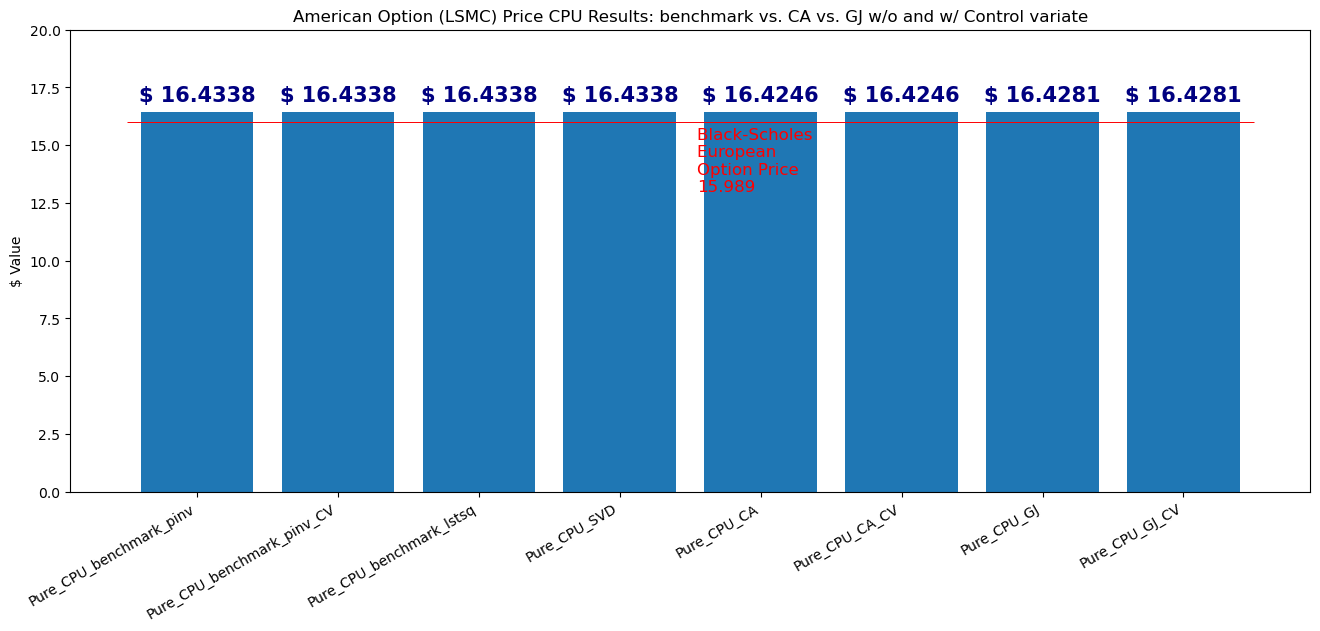

In [24]:
# Pure CPU: benchmark vs. CA vs. GJ w/o and w/ Control variate
print('*** European Option ***')
print('Black-Scholes price: $', BlackScholes(S0, K, r, sigma, T, opttype))
print('Monte Carlo price:   $', mcBase.getEuroOption())

print('\n*** American Option (LSMC) ***')
log = None   ## None or 'INFO'

results = []

# print(longstaff_schwartz_itm_path_fast2)
print('Pure CPU >>>')

inverseType = 'benchmark_pinv'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '(Numpy.linalg.pinv)', '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_bm_pinv, coef_np_bm_pinv, dc_cl_np_bm_pinv = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_bm_pinv = time.time() - ts
print('    Option price: $', C_hat_np_bm_pinv, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_bm_pinv*1e3))
results.append(np.round(C_hat_np_bm_pinv, 4))

toggleCV = 'ON'
print('  inversion type:', inverseType, '(Numpy.linalg.pinv)', '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_bm_pinv_CV, coef_np_bm_pinv_CV, dc_cl_np_bm_pinv_CV = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_bm_pinv_CV = time.time() - ts
print('    Option price: $', C_hat_np_bm_pinv_CV, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_bm_pinv_CV*1e3))
results.append(np.round(C_hat_np_bm_pinv_CV, 4))

inverseType = 'benchmark_lstsq'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '(Numpy.linalg.lstsq)', '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_bm_lstsq, coef_np_bm_lstsq, dc_cl_np_bm_lstsq = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_bm_lstsq = time.time() - ts
print('    Option price: $', C_hat_np_bm_lstsq, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_bm_lstsq*1e3))
results.append(np.round(C_hat_np_bm_lstsq, 4))

inverseType = 'SVD'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '(Numpy.linalg.svd)')
ts = time.time()
C_hat_np_SVD, coef_np_SVD, dc_cl_np_SVD = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_SVD = time.time() - ts
print('    Option price: $', C_hat_np_SVD, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_SVD*1e3))
results.append(np.round(C_hat_np_SVD, 4))

inverseType = 'CA'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_CA, coef_np_CA, dc_cl_np_CA = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_CA = time.time() - ts
print('    Option price: $', C_hat_np_CA, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_CA*1e3))
results.append(np.round(C_hat_np_CA, 4))

toggleCV = 'ON'
print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_CA_CV, coef_np_CA_CV, dc_cl_np_CA_CV = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_CA_CV = time.time() - ts
print('    Option price: $', C_hat_np_CA_CV, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_CA_CV*1e3))
results.append(np.round(C_hat_np_CA_CV, 4))

inverseType = 'GJ'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_GJ, coef_np_GJ, dc_cl_np_GJ = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_GJ = time.time() - ts
print('    Option price: $', C_hat_np_GJ, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_GJ*1e3))
results.append(np.round(C_hat_np_GJ, 4))

toggleCV = 'ON'
print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_np_GJ_CV, coef_np_GJ_CV, dc_cl_np_GJ_CV = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_GJ_CV = time.time() - ts
print('    Option price: $', C_hat_np_GJ_CV, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_GJ_CV*1e3))
results.append(np.round(C_hat_np_GJ_CV, 4))


fig, (ax1) = plt.subplots(1, 1, figsize=(16,6))

elapse = np.array([elapse_pureCPU_bm_pinv, 
                   elapse_pureCPU_bm_pinv_CV,
                   elapse_pureCPU_bm_lstsq,
                   elapse_pureCPU_SVD, 
                   elapse_pureCPU_CA,
                   elapse_pureCPU_CA_CV,
                   elapse_pureCPU_GJ,
                   elapse_pureCPU_GJ_CV,])

labels = ['Pure_CPU_benchmark_pinv',
          'Pure_CPU_benchmark_pinv_CV',
          'Pure_CPU_benchmark_lstsq',
          'Pure_CPU_SVD',
          'Pure_CPU_CA',
          'Pure_CPU_CA_CV',
          'Pure_CPU_GJ',
          'Pure_CPU_GJ_CV',]

bar1 = ax1.bar(np.arange(len(results)), results)
ax1.set_title('American Option (LSMC) Price CPU Results: benchmark vs. CA vs. GJ w/o and w/ Control variate')
ax1.set_ylabel('$ Value')
ax1.set_xticks(np.arange(len(results)), labels=labels, rotation=30, horizontalalignment='right')
ax1.set_ylim(ymax=20)
ax1.bar_label(bar1, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 15, padding=5, fontweight = 'bold')
ax1.hlines(BlackScholes(S0, K, r, sigma, T, opttype), -.5, 7.5, colors='r', lw=.7) 
ax1.text(3.55, 13., f'Black-Scholes \nEuropean \nOption Price \n{np.round(BlackScholes(S0, K, r, sigma, T, opttype),4)}', color = 'red', fontsize=12)

plt.show()

### Reset all initial variables

In [152]:
# use MC new simulation
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 110.0, 'P', 1000
mcBase = MonteCarloBase(S0, r, sigma, T, nPath, nPeriod, K, opttype)
St = mcBase.St
BS = mcBase.BS

In [153]:
print('*** European Option ***')
print('Black-Scholes price: $', BlackScholes(S0, K, r, sigma, T, opttype))
print('Monte Carlo price:   $', mcBase.getEuroOption())

print('\n*** American Option (LSMC) ***')
log = None   ## None or 'INFO'

results = []

# print(longstaff_schwartz_itm_path_fast2)
print('Pure CPU >>>')

inverseType = 'benchmark_lstsq'
print('  inversion type:', inverseType, '(Numpy.linalg.lstsq)')
ts = time.time()
C_hat_np_bm, coef_np_bm, dc_cl_np_bm = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_pureCPU_bm = time.time() - ts
print('    Option price: $', C_hat_np_bm, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_bm*1e3))
results.append(np.round(C_hat_np_bm, 4))

# inverseType = 'SVD'
# print('  inversion type:', inverseType, '(Numpy.linalg.svd)')
# ts = time.time()
# C_hat_np_SVD, coef_np_SVD, dc_cl_np_SVD = longstaff_schwartz_itm_path_fast2(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
# elapse_pureCPU_SVD = time.time() - ts
# print('    Option price: $', C_hat_np_SVD, '\n    Time elapse: {} ms\n'.format(elapse_pureCPU_SVD*1e3))
# results.append(np.round(C_hat_np_SVD, 4))

# print(longstaff_schwartz_itm_path_fast2_hybrid)
print('-------------\nOpenCL GPU >>>')

# pre-run for cold start
inverseType = 'CA'
toggleCV = 'OFF'
C_hat_hyb_GPU_CA, coef_hyb_GPU_CA, dc_cl_hyb_GPU_CA = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)

# print('  inversion type: hybrid_SVD', '| toggleCV:', toggleCV)
# ts = time.time()
# C_hat_hyb_GPU_SVD, coef_hyb_GPU_SVD, dc_cl_hyb_GPU_SVD = longstaff_schwartz_itm_path_fast2_hybrid_SVD(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
# elapse_openCL_GPU_SVD = time.time() - ts
# print('    Option price: $', C_hat_hyb_GPU_SVD, '\n    Time elapse: {} ms'.format(elapse_openCL_GPU_SVD*1e3))
# results.append(np.round(C_hat_hyb_GPU_SVD, 4))

inverseType = 'CA'
toggleCV = 'OFF'
print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_hyb_GPU_CA, coef_hyb_GPU_CA, dc_cl_hyb_GPU_CA = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_openCL_GPU_CA = time.time() - ts
print('    Option price: $', C_hat_hyb_GPU_CA, '\n    Time elapse: {} ms'.format(elapse_openCL_GPU_CA*1e3))
results.append(np.round(C_hat_hyb_GPU_CA, 4))

# toggleCV = 'ON'
# print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
# ts = time.time()
# C_hat_hyb_GPU_CA_CV, coef_hyb_GPU_CA_CV, dc_cl_hyb_GPU_CA_CV = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
# elapse_openCL_GPU_CA_CV = time.time() - ts
# print('    Option price: $', C_hat_hyb_GPU_CA_CV, '\n    Time elapse: {} ms'.format(elapse_openCL_GPU_CA_CV*1e3))
# results.append(np.round(C_hat_hyb_GPU_CA_CV, 4))

inverseType = 'GJ'
toggleCV = 'OFF'
print('\n  inversion type:', inverseType, '| toggleCV:', toggleCV)
ts = time.time()
C_hat_hyb_GPU_GJ, coef_hyb_GPU_GJ, dc_cl_hyb_GPU_GJ = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
elapse_openCL_GPU_GJ = time.time() - ts
print('    Option price: $', C_hat_hyb_GPU_GJ, '\n    Time elapse: {} ms'.format(elapse_openCL_GPU_GJ*1e3))
results.append(np.round(C_hat_hyb_GPU_GJ, 4))

# toggleCV = 'ON'
# print('  inversion type:', inverseType, '| toggleCV:', toggleCV)
# ts = time.time()
# C_hat_hyb_GPU_GJ_CV, coef_hyb_GPU_GJ_CV, dc_cl_hyb_GPU_GJ_CV = longstaff_schwartz_itm_path_fast2_hybrid(St, K, T, r, opttype, BS, inverseType=inverseType, toggleCV=toggleCV, log=log)
# elapse_openCL_GPU_GJ_CV = time.time() - ts
# print('    Option price: $', C_hat_hyb_GPU_GJ_CV, '\n    Time elapse: {} ms'.format(elapse_openCL_GPU_GJ_CV*1e3))
# results.append(np.round(C_hat_hyb_GPU_GJ_CV, 4))


*** European Option ***
Black-Scholes price: $ 15.989035403985838
Monte Carlo price:   $ 15.94405

*** American Option (LSMC) ***
Pure CPU >>>
  inversion type: benchmark_lstsq (Numpy.linalg.lstsq)
    Option price: $ 16.483924100931443 
    Time elapse: 956.9242000579834 ms

-------------
OpenCL GPU >>>
  inversion type: CA | toggleCV: OFF
    Option price: $ 16.482643043104527 
    Time elapse: 198.87304306030273 ms

  inversion type: GJ | toggleCV: OFF
    Option price: $ 16.47310384909095 
    Time elapse: 188.51780891418457 ms


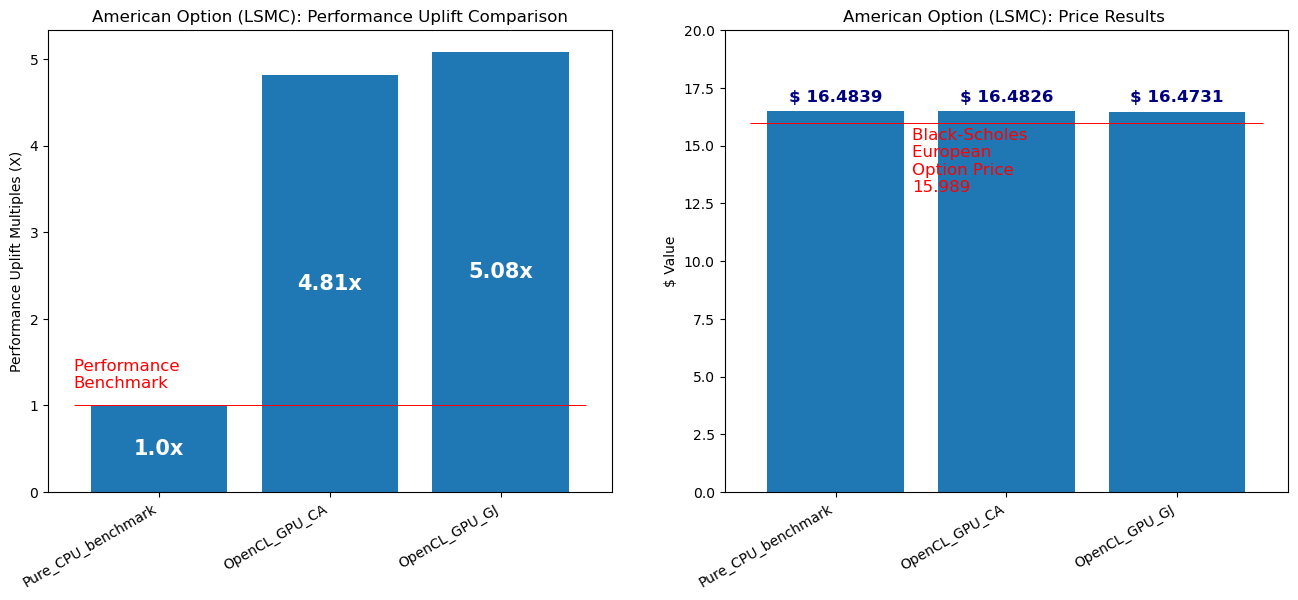

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapse = np.array([elapse_pureCPU_bm, 
                   elapse_openCL_GPU_CA, 
#                    elapse_openCL_GPU_CA_CV, 
                   elapse_openCL_GPU_GJ, 
#                    elapse_openCL_GPU_GJ_CV,
                  ])

labels = ['Pure_CPU_benchmark',
          'OpenCL_GPU_CA', 
#           'OpenCL_GPU_CA_CV', 
          'OpenCL_GPU_GJ', 
#           'OpenCL_GPU_GJ_CV',
         ]

uplift = list(np.round(elapse_pureCPU_bm / elapse, 2))

bar1 = ax1.bar(np.arange(len(results)), uplift)
ax1.set_title('American Option (LSMC): Performance Uplift Comparison')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(results)), labels=labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 15, fontweight = 'bold')
# ax1.hlines(1, -.5, 4.5, colors='r', lw=.7) 
ax1.hlines(1, -.5, 2.5, colors='r', lw=.7) 
ax1.text(-.5, 1.2, 'Performance \nBenchmark', color = 'red', fontsize=12)

bar2 = ax2.bar(np.arange(len(results)), results)
ax2.set_title('American Option (LSMC): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(results)), labels=labels, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 12, padding=5, fontweight = 'bold')
# ax2.hlines(BlackScholes(S0, K, r, sigma, T, opttype), -.5, 4.5, colors='r', lw=.7) 
ax2.hlines(BlackScholes(S0, K, r, sigma, T, opttype), -.5, 2.5, colors='r', lw=.7) 
ax2.text(.45, 13., f'Black-Scholes \nEuropean \nOption Price \n{np.round(BlackScholes(S0, K, r, sigma, T, opttype),4)}', color = 'red', fontsize=12)

plt.show()

In [81]:
idx=[0, 1, 3]
results2 = np.array(results)[idx]
results2

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapse = np.array([elapse_pureCPU_bm, 
                   elapse_openCL_GPU_CA, 
                   elapse_openCL_GPU_GJ, 
                  ])

labels = ['Pure_CPU_benchmark',
          'OpenCL_GPU_CA', 
          'OpenCL_GPU_GJ', 
         ]

uplift = list(np.round(elapse_pureCPU_bm / elapse, 2))

bar1 = ax1.bar(np.arange(len(labels)), uplift)
ax1.set_title('American Option (LSMC): Performance Uplift Comparison')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(labels)), labels=labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 15, fontweight = 'bold')
ax1.hlines(1, -.5, 2.5, colors='r', lw=.7) 
ax1.text(-.5, 1.2, 'Performance \nBenchmark', color = 'red', fontsize=12)

bar2 = ax2.bar(np.arange(len(results2)), results2)
ax2.set_title('American Option (LSMC): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(results2)), labels=labels, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 15, padding=5, fontweight = 'bold')
ax2.hlines(BlackScholes(S0, K, r, sigma, T, opttype), -.5, 2.5, colors='r', lw=.7) 
ax2.text(-.33, 12.2, f'Black-Scholes \nEuropean \nOption Price \n${BlackScholes(S0, K, r, sigma, T, opttype):0.4f}', color = 'red', fontsize=12)

plt.show()

#### Convergence

In [420]:
dc_cl_np_bm.shape, coef_np_bm.shape

((199, 20000), (199, 3))

In [421]:
# Mean Square Errors
mse_coef_CA = []
mse_dc_cf_CA = []
mse_coef_CA_CV = []
mse_dc_cf_CA_CV = []

mse_coef_GJ = []
mse_dc_cf_GJ = []
mse_coef_GJ_CV = []
mse_dc_cf_GJ_CV = []

for i in range(nPeriod-1):
    mse_coef_CA.append(mse(coef_np_bm[i], coef_hyb_GPU_CA[i]))
    mse_dc_cf_CA.append(mse(dc_cl_np_bm[i], dc_cl_hyb_GPU_CA[i]))
    mse_coef_CA_CV.append(mse(coef_np_bm[i], coef_hyb_GPU_CA_CV[i]))
    mse_dc_cf_CA_CV.append(mse(dc_cl_np_bm[i], dc_cl_hyb_GPU_CA_CV[i]))
    
    mse_coef_GJ.append(mse(coef_np_bm[i], coef_hyb_GPU_GJ[i]))
    mse_dc_cf_GJ.append(mse(dc_cl_np_bm[i], dc_cl_hyb_GPU_GJ[i]))
    mse_coef_GJ_CV.append(mse(coef_np_bm[i], coef_hyb_GPU_GJ_CV[i]))
    mse_dc_cf_GJ_CV.append(mse(dc_cl_np_bm[i], dc_cl_hyb_GPU_GJ_CV[i]))
    
mse_coef_CA = np.array(mse_coef_CA)
mse_dc_cf_CA = np.array(mse_dc_cf_CA)
mse_coef_CA_CV = np.array(mse_coef_CA_CV)
mse_dc_cf_CA_CV = np.array(mse_dc_cf_CA_CV)

mse_coef_GJ = np.array(mse_coef_GJ)
mse_dc_cf_GJ = np.array(mse_dc_cf_GJ)
mse_coef_GJ_CV = np.array(mse_coef_GJ_CV)
mse_dc_cf_GJ_CV = np.array(mse_dc_cf_GJ_CV)

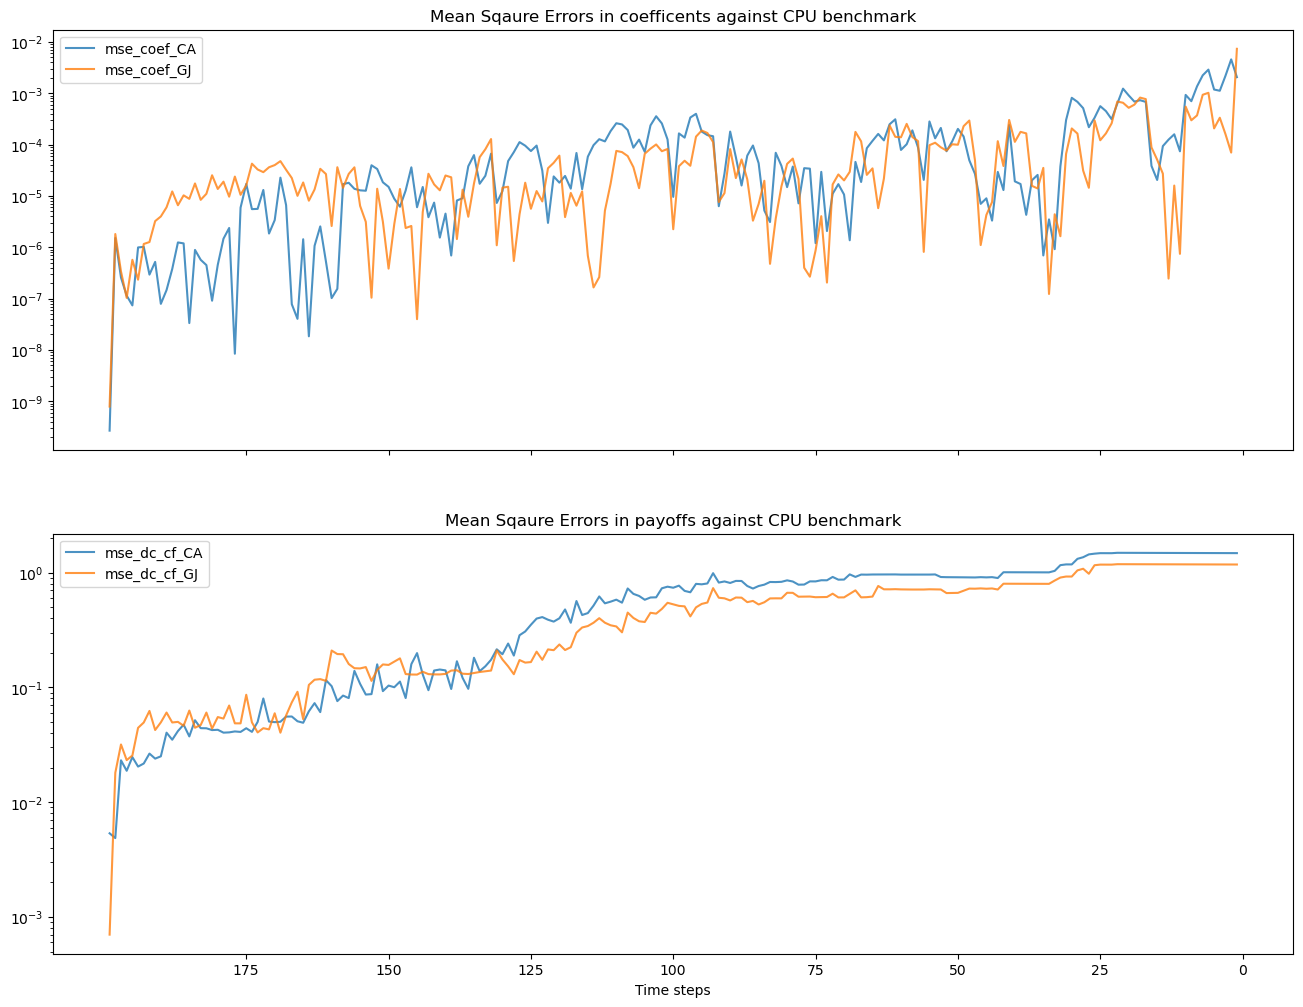

In [422]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,12))
ax1.semilogy(np.arange(0, len(mse_coef_CA), 1), mse_coef_CA, alpha=.8, label='mse_coef_CA')
# ax1.semilogy(np.arange(0, len(mse_coef_CA_CV), 1), mse_coef_CA_CV, alpha=.6, label='mse_coef_CA_CV')
ax1.semilogy(np.arange(0, len(mse_coef_GJ), 1), mse_coef_GJ, alpha=.8, label='mse_coef_GJ')
# ax1.semilogy(np.arange(0, len(mse_coef_GJ_CV), 1), mse_coef_GJ_CV, alpha=1, label='mse_coef_GJ_CV')
ax1.set_title('Mean Sqaure Errors in coefficents against CPU benchmark')
ax1.legend()

ax2.semilogy(np.arange(0, len(mse_dc_cf_CA), 1), mse_dc_cf_CA, alpha=.8, label='mse_dc_cf_CA')
# ax2.semilogy(np.arange(0, len(mse_dc_cf_CA_CV), 1), mse_dc_cf_CA_CV, alpha=.6, label='mse_dc_cf_CA_CV')
ax2.semilogy(np.arange(0, len(mse_dc_cf_GJ), 1), mse_dc_cf_GJ, alpha=.8, label='mse_dc_cf_GJ')
# ax2.semilogy(np.arange(0, len(mse_dc_cf_GJ_CV), 1), mse_dc_cf_GJ_CV, alpha=1, label='mse_dc_cf_GJ_CV')
ax2.set_title('Mean Sqaure Errors in payoffs against CPU benchmark')
ax2.legend()

# ax2.invert_xaxis()
xticks = list(range(24, nPeriod, 25))
ax2.set_xticks(xticks)
ax2.set_xticklabels([nPeriod-1-x for x in xticks])

plt.xlabel('Time steps')
plt.show()

### Linear Regression & Least square method comparison

$ \begin{cases}
    a_{00} x_{0} + a_{01} x_{1} + a_{02} x_{2} +...+ a_{0m} x_m = b_0 \\
    a_{10} x_{0} + a_{11} x_{1} + a_{12} x_{2} +...+ a_{1m} x_m= b_1 \\
    a_{20} x_{0} + a_{21} x_{1} + a_{22} x_{2} +...+ a_{2m} x_m= b_2 \\
    ... \\
    a_{n0} x_{0} + a_{n1} x_{1} + a_{n2} x_{2} +...+ a_{nm} x_m= b_n 
\end{cases}$ 
$\quad$it can be presented as $\quad$<p>

$
\left(\begin{matrix}
x_{00} \ x_{01} \ x_{02} \ ... \ x_{0m}  \\
x_{10} \ x_{11} \ x_{12} \ ... \ x_{1m}  \\
x_{20} \ x_{21} \ x_{22} \ ... \ x_{2m}  \\
... \\
x_{n0} \ x_{n1} \ x_{n2} \ ... \ x_{nm}  
\end{matrix}\right)_{n·m}
\quad \cdot \quad
\left(\begin{matrix}
\beta_0 \\ \beta_1 \\ \beta_2 \\ ... \\ \beta_m
\end{matrix}\right)_{m·1}
\quad = \quad
\left(\begin{matrix}
y_0 \\
y_1 \\
y_2 \\
... \\
y_n
\end{matrix}\right)_{n·1}
$<p>
    
For n data pairs $(x_i, y_i)$ and its model function $f(x, \beta)$, the measurment of residual is defined as the deifference between the observed data values of the dependent variables and the model predicted ones:<p>
$r_i = y_i - f(x, \beta)$, where $i \in [0,n)$<p>
The least square methods find the optimal parameters that minimize the sum of squared residuals, denoted as:
$S = \Sigma_{i=0}^{n-1} r_i^2$

In [ ]:
# 1000 or 200000 as of nPath from the simulation, divided by 2 to approximate "in-the-money" paths
sim_length = int(20 / 2)

a = np.sort(np.random.randn(sim_length))
b = np.random.randn(sim_length)
# a, b

##### Examine Different Methods For Coefficients
* performance (custom function, Linalg.inv, Linalg.pinv, Linalg.lstsq)
* accuracy with benchmark of NumPy.polfit & NumPy.polval functions

In [ ]:
A = np.c_[np.ones(len(a)), a, np.square(a)]

##### Performance comparison

In [ ]:
%timeit -n10000 -r7 (inverse_3X3_matrix(A.T @ A)[1] @ A.T) @ b 
%timeit -n10000 -r7 (la.inv(A.T @ A) @ A.T) @ b
%timeit -n10000 -r7 (la.pinv(A)) @ b
%timeit -n10000 -r7 la.lstsq(A, b, rcond=None)

##### Stability & Accuracy

In [ ]:
# Benchmark
betas_2 = np.polyfit(a, b, 2)
betas_2

In [ ]:
iter_ = 20000
mses_all = np.zeros((iter_, 4))

for i in range(iter_):
    a = np.sort(np.random.randn(10))
    b = np.random.randn(10)
    
    betas_2 = np.polyfit(a, b, 2)
    A = np.c_[np.ones(len(a)), a, np.square(a)]
    
    mses = np.zeros(4)
    mses[0] = mse(np.flip(betas_2), (inverse_3X3_matrix(A.T @ A)[1] @ A.T) @ b)
    mses[1] = mse(np.flip(betas_2), (la.inv(A.T @ A) @ A.T) @ b)
    mses[2] = mse(np.flip(betas_2), (la.pinv(A)) @ b)
    mses[3] = mse(np.flip(betas_2), la.lstsq(A, b, rcond=None)[0])
    
    mses_all[i] = mses

In [ ]:
df_mses_all = pd.DataFrame(mses_all, columns=['inverse_3x3', 'np_linalg_inv', 'np_linalg_pinv', 'np_linalg_lstsq'])
df_mses_all.mean().sort_values(ascending=True)

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.semilogy(df_mses_all.mean(), 'r*', alpha=.6, markersize=20)
plt.title('mean MSE with {} iterations'.format(iter_))
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.semilogy(df_mses_all.inverse_3x3, label='inverse_3x3', alpha=.2)
plt.semilogy(df_mses_all.np_linalg_inv, label='np_linalg_inv', alpha=.2)
plt.semilogy(df_mses_all.np_linalg_pinv, label='np_linalg_pinv', alpha=1)
plt.semilogy(df_mses_all.np_linalg_lstsq, label='np_linalg_lstsq', alpha=.2)
plt.legend()
plt.title('MSE Convergence with {} iterations'.format(iter_))
plt.show()